<a href="https://colab.research.google.com/github/yongsa-nut/TU_CN240_DataScience_671/blob/main/HW7_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW 7: Spam/Ham Classification with Logistic Regression

## Due: November, 8th 2024

### Point: 5

## Introduction

You will use what you've learned in class to create a binary classifier that can distinguish spam (junk, commercial, or bulk) emails from ham (regular non-spam) emails.

The homework consists of 5 parts:
- Initial Analysis of the data
- Feature Engineering
- EDA
- Basic Classification
- Evaluating Classification

In [ ]:
# Run this cell to suppress all FutureWarnings.
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
import numpy as np
import pandas as pd
from plotnine import *

<br>

---

## Data

In email classification, **our goal is to classify emails as spam or not spam** (referred to as "ham") using features generated from the text in the email. The dataset is from [SpamAssassin](https://spamassassin.apache.org/old/publiccorpus/). It consists of email messages and their labels (0 for ham, 1 for spam). Your labeled training dataset contains 8,348 labeled examples.

**Note:** The dataset is from 2004, so the contents of emails might be very different from those in 2024.

Run the following cells to load the data into a `DataFrame`.

The `train` `DataFrame` contains labeled data you will use to train your model. It has four columns:

1. `id`: An identifier for the training example.
1. `subject`: The subject of the email.
1. `email`: The text of the email.
1. `spam`: 1 if the email is spam, 0 if the email is ham (not spam).

In [ ]:
# Download and unzip the data file
!wget https://github.com/yongsa-nut/TU_CN240_DataScience_671/raw/refs/heads/main/Data/spam_train.zip
!unzip spam_train

In [ ]:
# Loading training datasets
original_training_data = pd.read_csv('/content/spam_train.csv')

# Convert the emails to lowercase as the first step of text processing.
original_training_data['email'] = original_training_data['email'].str.lower()

original_training_data.head()

<br/>

First, let's check if our data contains **any missing values**. We have filled in the cell below to print the number of `NaN` values in each column. If there are `NaN` values, we replace them with appropriate filler values (i.e., `NaN` values in the `subject` or `email` columns will be replaced with empty strings). Finally, we print the number of `NaN` values in each column after this modification to verify that there are no `NaN` values left.

**Note:** While there are no `NaN` values in the `spam` column, we should be careful when replacing `NaN` labels. Doing so without consideration may introduce significant bias into our model.

In [ ]:
print('Before imputation:')
print(original_training_data.isnull().sum())
original_training_data = original_training_data.fillna('')
print('------------')
print('After imputation:')
print(original_training_data.isnull().sum())

<br/>

---

## Part 1: Initial Analysis

In the cell below, we have printed the text of the `email` field for the first ham and the first spam email in the original training set.

In [ ]:
first_ham = original_training_data.loc[original_training_data['spam'] == 0, 'email'].iloc[0]
first_spam = original_training_data.loc[original_training_data['spam'] == 1, 'email'].iloc[0]
print("Ham Email:")
print(first_ham)
print("-------------------------------------------------")
print("Spam Email:")
print(first_spam)

### Question 1 (0.2)

Discuss one attribute or characteristic you notice that is different between the two emails that may allow you to uniquely identify a spam email.

Answer: _Type your answer here, replacing this text._

### Training-Validation Split

The training data we downloaded is all the data we have available for both training models and **validating** the models that we train. We, therefore, need to split the training data into separate training and validation datasets. You will need this **validation data** to assess the performance of your classifier once you are finished training. Note that we set the seed (`random_state`) to 42. This will produce a pseudo-random sequence of random numbers that is the same for every student.

**Do not modify this random seed in the following questions, as our tests depend on it.**

In [ ]:
# This creates a 90/10 train-validation split on our labeled data.
from sklearn.model_selection import train_test_split

train, val = train_test_split(original_training_data, test_size = 0.1, random_state = 42)

<br>

---

## Part 2: Feature Engineering

We want to take the text of an email and predict whether the email is ham or spam. This is a **binary classification** problem, so we can use logistic regression to train a classifier. Recall that to train a logistic regression model, we need a numeric feature matrix $\mathbb{X}$ and a vector of corresponding binary labels $Y$. Unfortunately, our data are text, not numbers. To address this, we can create numeric features derived from the email text and use those features for logistic regression.

Each row of $\mathbb{X}$ is an email. Each column of $\mathbb{X}$ contains one feature for all the emails. We'll guide you through creating a simple feature, and you'll create more interesting ones as you try to increase the accuracy of your model.

### Question 2 (0.5 point)

Create a function `words_in_texts` that takes in a list of interesting words (`words`) and a `Series` of emails (`texts`). Our goal is to check if each word in `words` is contained in the emails in `texts`.

The `words_in_texts` function should output a **2-dimensional `NumPy` array** that contains one row for each email in `texts` and one column for each word in `words`. If the $j$-th word in `words` is present at least once in the $i$-th email in `texts`, the output array should have a value of 1 at the position $(i, j)$. Otherwise, if the $j$-th word is not present in the $i$-th email, the value at $(i, j)$ should be 0.

We will be applying `words_in_texts` to some large datasets, so implementing some form of vectorization (for example, using `NumPy` arrays, `Series.str` functions, etc.) is highly recommended.

For example:
```
>>> words_in_texts(['hello', 'bye', 'world'],
                   pd.Series(['hello', 'hello worldhello']))

array([[1, 0, 0],
       [1, 0, 1]])
```

Importantly, we **do not** calculate the *number of occurrences* of each word; only if the word is present at least *once*. Take a moment to work through the example on your own if need be —— understanding what the function does is a critical first step in implementing it.

**Note**: You can convert a list to a numpy array using `np.array(lst)`

In [ ]:
def words_in_texts(words, texts):
    """
    Args:
        words (list): Words to find.
        texts (Series): Strings to search in.

    Returns:
        A 2D NumPy array of 0s and 1s with shape (n, d) where
        n is the number of texts, and d is the number of words.
    """
    indicator_array = ...
    return indicator_array

In [ ]:
# Run this cell to see what your function outputs. Compare the results to the example provided above.
words_in_texts(['hello', 'bye', 'world'], pd.Series(['hello', 'hello worldhello']))

## Part 3: EDA

We need to identify some features that allow us to distinguish spam emails from ham emails. One idea is to **compare the distribution of a single feature in spam emails to the distribution of the same feature in ham emails**.

Suppose the feature is a binary indicator, such as whether a particular word occurs in the text. In that case, this compares the proportion of spam emails with the word to the proportion of ham emails with the word.

### Question 3 (1 point)

Create the bar chart as shown below by comparing the proportion of spam and ham emails containing specific words.

- **Choose a set of 6 words other than those shown in the example.**
- These words should have different proportions for the two classes (i.e., noticeably different bar heights across spam and ham).
- Your `words_in_texts` function from the previous part will be useful here.

**Hint 1:** This is a pretty challenging question. The suggested approach is to first look at the example bar plot and make sure you can interpret what is being plotted - what does a bar represent? What does the height mean?

**Hint 2:** You may want to start by replicating the plot below first.

**Hint 3:** You may want to use `numpy.sum(axis=0)` to sum only the first dimension (row)

**Hint 4:** You will want to set `geom_bar` as follows `geom_bar(stat='identity', position='dodge')`

Finally, you will need to chain some `pandas` functions together. Try to add one function at a time and see how that affects the `DataFrame`. It may help to use a new cell or print out the `DataFrame` for debugging purposes as you work towards achieving the desired format above.

In [ ]:
# Example of ansnwer. YOU MUST NOT USE THESE WORDS!

,word,type,percentage
0,body,Ham,0.123682
1,business,Ham,0.087042
2,html,Ham,0.222163
3,money,Ham,0.058266
4,offer,Ham,0.062198
5,please,Ham,0.099553
6,body,Spam,0.519812
7,business,Spam,0.257039
8,html,Spam,0.595412
9,money,Spam,0.232534


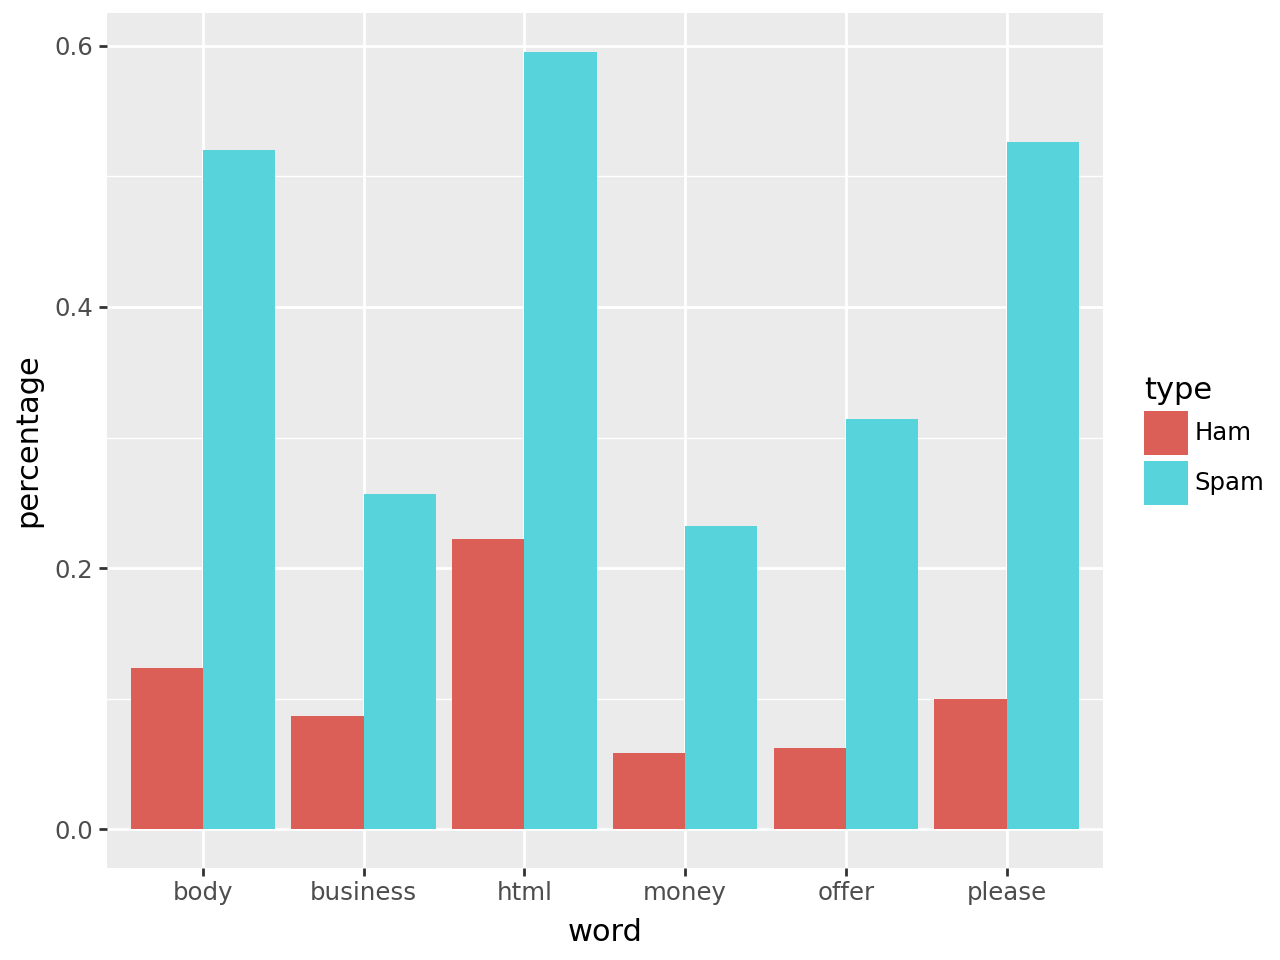

In [ ]:
# Example of ansnwer. YOU MUST NOT USE THESE WORDS!

When the feature is binary, it makes sense to compare its proportions across classes (as in the previous question). Otherwise, if the feature can take on numeric values, we can compare the distributions of these values for different classes.

Create your bar chart in the following cell:

In [ ]:
train = train.reset_index(drop=True) # We must do this in order to preserve the ordering of emails to labels for words_in_texts.

...

<br>

---

## Part 4: Basic Classification

Notice that the output of `words_in_texts(words, train['email'])` is a numeric matrix containing features for each email. This means we can use it directly to train a classifier!

### Question 4 (0.5)

We've given you 5 words that might be useful as features to distinguish spam/ham emails.

**Use these words** (`some_words`) and the `train` `DataFrame` to create two `NumPy` arrays: `X_train` and `Y_train`.
- `X_train` should be a 2D array of 0s and 1s created using your `words_in_texts` function on all the emails in the training set.
-  `Y_train` should be a vector of the correct labels for each email in the training set.

In [ ]:
some_words = ['drug', 'bank', 'prescription', 'memo', 'private']

X_train = ...
Y_train = ...

X_train[:5], Y_train[:5]

(array([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0]]),
 0    0
 1    0
 2    0
 3    0
 4    0
 Name: spam, dtype: int64)

### Question 5 (0.5)

Now that we have matrices, we can build a model with `sklearn`! Using the [`LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) classifier, train a logistic regression model using `X_train` and `Y_train`. Then, output the model's training accuracy below. You should get an accuracy of around $0.76$.

In [ ]:
from sklearn.linear_model import LogisticRegression

my_model = ...
...

training_accuracy = ...
print("Training Accuracy: ", training_accuracy)

<br>

---

## Part 5: Evaluating Classifiers

That doesn't seem too shabby! But the classifier you made above isn't as good as the accuracy would make you believe. First, we are evaluating the accuracy of the model on the training set, which may be a misleading measure. Accuracy on the training set doesn't always translate to accuracy in the real world (on the test set).

Presumably, our classifier will be used for **filtering**, or preventing messages labeled `spam` from reaching someone's inbox. There are two kinds of errors we can make:
- **False positive (FP)**: A ham email gets flagged as spam and filtered out of the inbox.
- **False negative (FN)**: A spam email gets mislabeled as ham and ends up in the inbox.

To be clear, we label spam emails as 1 and ham emails as 0. These definitions depend both on the true labels and the predicted labels. False positives and false negatives may be of differing importance, leading us to consider more ways of evaluating a classifier in addition to overall accuracy:

**Precision**: Measures the proportion of emails flagged as spam that are actually spam. Mathematically, $\frac{\text{TP}}{\text{TP} + \text{FP}}$.

**Recall**: Measures the proportion  of spam emails that were correctly flagged as spam. Mathematically, $\frac{\text{TP}}{\text{TP} + \text{FN}}$.

**False positive rate**: Measures the proportion  of ham emails that were incorrectly flagged as spam. Mathematically, $\frac{\text{FP}}{\text{FP} + \text{TN}}$.

One quick mnemonic to remember the formulas is that **P**recision involves T**P** and F**P**, Recall does not.

Note that a True Positive (TP) is a spam email that is classified as spam, and a True Negative (TN) is a ham email that is classified as ham.

### Question 6a (0.2 points)

Suppose we have a hypothetical classifier called the “zero predictor.” For any inputted email, **the zero predictor *always* predicts 0 (it never makes a prediction of 1 for any email)**. (Recall: 0 is ham and 1 is spam)

How many false positives and false negatives would this classifier have if it were evaluated on the training set and its results were compared to `Y_train`?

Assign `zero_predictor_fp` to the number of false positives and `zero_predictor_fn` to the number of false negatives for the hypothetical zero predictor on the training data.

In [ ]:
zero_predictor_fp = ...
zero_predictor_fn = ...
zero_predictor_fp, zero_predictor_fn

(0, 1918)

### Question 6b (0.2 points)

What is the accuracy and recall of the zero predictor on the training data? Do not use any `sklearn` functions to compute these performance metrics.

In [ ]:
zero_predictor_tp = ...
zero_predictor_acc = ...
zero_predictor_recall = ...
zero_predictor_tp, zero_predictor_acc, zero_predictor_recall

(0.7447091707706642, 1.0)

### Question 6c (0.2 points)

Explain your results in `q6a` and `q6b`. How did you know what to assign to `zero_predictor_fp`, `zero_predictor_fn`, `zero_predictor_acc`, and `zero_predictor_recall`?

Answer: _Type your answer here, replacing this text._

### Question 6d (0.4 points)

Compute the precision, recall, and false positive rate of the `LogisticRegression` classifier `my_model` from Question 5. Do **not** use any `sklearn` functions to compute performance metrics; the only `sklearn` method you may use here is `.predict` to generate model predictions using `my_model` and `X_train`.

In [ ]:
Y_train_hat = ...

TP = ...
TN = ...
FP = ...
FN = ...
logistic_predictor_precision = ...
logistic_predictor_recall = ...

print(f"{TP=}, {TN=}, {FP=}, {FN=}")
print(f"{logistic_predictor_precision=:.2f}, {logistic_predictor_recall=:.2f}")

### Question 6e (0.2 points)

Is the number of false positives produced by the logistic regression classifier `my_model` strictly greater than the number of false negatives produced? Assign to `q6e` an expression that evaluates to give your answer (`True` or `False`).

In [ ]:
q6e = ...
q6e

### Question 6f (0.2 points)

How does the accuracy of the logistic regression classifier `my_model` compare to the accuracy of the zero predictor?

Answer: _Type your answer here, replacing this text._

### Question 6g (0.2 points)

Given the word features provided in Question 4, discuss why the logistic regression classifier `my_model` may be performing poorly.

**Hint:** Think about how prevalent these words are in the email set.

Answer: _Type your answer here, replacing this text._

### Question 6h (0.2 points)

Would you prefer to use the logistic regression classifier `my_model` or the zero predictor classifier for a spam filter? Why? Describe your reasoning and relate it to at least one of the evaluation metrics you have computed so far.

Answer: _Type your answer here, replacing this text._

<br>

---

## Part 6: Use your words

### Q7 (0.5 point)

- Repeat Part 4 with your chosen 6 words.
- Report both training accuracy and validation accuracy.

In [ ]:
...

training_accuracy = ...
print("Training Accuracy: ", training_accuracy)
validation_accuracy = ...
print("Validation Accuracy: ", validation_accuracy)